<a href="https://colab.research.google.com/github/cmfritz/capstone/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import packages
import pandas as pd
import numpy as np
import string
import re
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist, word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud, STOPWORDS

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, precision_recall_curve, f1_score, recall_score
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My Drive/Github/capstone

/content/gdrive/My Drive/Github/capstone


In [ ]:
df = pd.read_pickle('data/master_data.pkl')
df = df.drop('claim_number', axis=1)
df

,patent_id,text
0,10873754,"1. A method for encoding video data, wherein t..."
1,10873755,1. A computer-implemented method of motion est...
2,10873756,"1. A video processing method, comprising: cons..."
3,10873757,1. A method of decoding video data in uni-dire...
4,10873758,1. An image processing device comprising: a se...
...,...,...
557406,10395357,1. An apparatus for detecting foam in a specim...
557407,10395358,1. A system configured to detect defects on a ...
557408,10395359,1. A system configured to detect defects on a ...
557409,10395360,1. An inspection system for inspecting an obje...


In [ ]:
df_pats_w_sectors = pd.read_csv('data/pats_w_sectors.csv')
df_pats_w_sectors

,Unnamed: 0,patent_id,sector_title,field_title
0,0,3930271,Other fields,"Furniture, games"
1,1,3930272,Other fields,"Furniture, games"
2,2,3930281,Other fields,"Furniture, games"
3,3,3930331,Other fields,"Furniture, games"
4,4,3930332,Other fields,"Furniture, games"
...,...,...,...,...
10296072,10296072,10818805,Chemistry,Micro-structural and nano-technology
10296073,10296073,10818835,Chemistry,Micro-structural and nano-technology
10296074,10296074,10818922,Chemistry,Micro-structural and nano-technology
10296075,10296075,10823691,Chemistry,Micro-structural and nano-technology


In [ ]:
len(set(df_pats_w_sectors.patent_id))

6836110

In [ ]:
counts = df_pats_w_sectors.patent_id.value_counts()
counts

9870654     16
9897587     14
9921166     14
9833978     14
9938184     14
            ..
6422240      1
10610403     1
6414052      1
6397676      1
4196353      1
Name: patent_id, Length: 6836110, dtype: int64

In [ ]:
counts = counts.to_frame()

In [ ]:
counts = counts.reset_index()

In [ ]:
groups = df_pats_w_sectors.groupby(by='patent_id').count()
groups[groups.sector_title > 1]

,Unnamed: 0,sector_title,field_title
patent_id,,,
3930275,3,3,3
3930276,2,2,2
3930280,2,2,2
3930287,2,2,2
3930288,2,2,2
...,...,...,...
10859662,2,2,2
10861271,2,2,2
10870348,2,2,2


In [ ]:
df_pats_w_sectors = df_pats_w_sectors.drop(['Unnamed: 0', 'field_title'], axis=1)
df_pats_w_sectors

,patent_id,sector_title
0,3930271,Other fields
1,3930272,Other fields
2,3930281,Other fields
3,3930331,Other fields
4,3930332,Other fields
...,...,...
10296072,10818805,Chemistry
10296073,10818835,Chemistry
10296074,10818922,Chemistry
10296075,10823691,Chemistry


In [ ]:
df_pats_w_sectors = df_pats_w_sectors.drop_duplicates()
df_pats_w_sectors

,patent_id,sector_title
0,3930271,Other fields
1,3930272,Other fields
2,3930281,Other fields
3,3930331,Other fields
4,3930332,Other fields
...,...,...
10296070,10818791,Chemistry
10296071,10818792,Chemistry
10296072,10818805,Chemistry
10296073,10818835,Chemistry


In [ ]:
df_pats_w_sectors.value_counts()

patent_id  sector_title          
10880932   Instruments               1
6291635    Chemistry                 1
6291625    Chemistry                 1
6291626    Chemistry                 1
           Electrical engineering    1
                                    ..
8640665    Mechanical engineering    1
8640666    Electrical engineering    1
8640667    Mechanical engineering    1
8640668    Mechanical engineering    1
3930271    Other fields              1
Length: 8272355, dtype: int64

In [ ]:
groups2 = df_pats_w_sectors.groupby(by='patent_id').count()
singles = groups2[groups2.sector_title == 1]

In [ ]:
len(singles)

5534114

In [ ]:
singles = singles.reset_index()
ok_pats = df_pats_w_sectors.merge(singles, on='patent_id')
ok_pats

,patent_id,sector_title_x,sector_title_y
0,3930271,Other fields,1
1,3930272,Other fields,1
2,3930281,Other fields,1
3,3930331,Other fields,1
4,3930332,Other fields,1
...,...,...,...
5534109,10800650,Chemistry,1
5534110,10807862,Chemistry,1
5534111,10807863,Chemistry,1
5534112,10815120,Chemistry,1


In [ ]:
ok_pats = ok_pats.drop(['sector_title_y'], axis=1)
ok_pats = ok_pats.rename(columns={'sector_title_x':'sector'})
ok_pats

,patent_id,sector
0,3930271,Other fields
1,3930272,Other fields
2,3930281,Other fields
3,3930331,Other fields
4,3930332,Other fields
...,...,...
5534109,10800650,Chemistry
5534110,10807862,Chemistry
5534111,10807863,Chemistry
5534112,10815120,Chemistry


In [ ]:
ok_pats.patent_id = ok_pats.patent_id.astype('int64')
ok_pats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5534114 entries, 0 to 5534113
Data columns (total 2 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   patent_id  int64 
 1   sector     object
dtypes: int64(1), object(1)
memory usage: 126.7+ MB


In [ ]:
# inner join with claims text
df_master = ok_pats.merge(df, how='inner', on='patent_id')
df_master

,patent_id,sector,text
0,9227092,Other fields,1. A safety rope blocker comprising: a body th...
1,9227100,Other fields,1. A portable physical exercise support stand ...
2,9227101,Other fields,"1. A training apparatus, comprising: an endles..."
3,9227102,Other fields,1. A bike trainer apparatus to be coupled to a...
4,9227103,Other fields,1. A fitness device comprising: a body having ...
...,...,...,...
406278,10435292,Chemistry,1. A method for producing a semiconductor modu...
406279,10442681,Chemistry,1. A micromechanical system provided with a se...
406280,10442683,Chemistry,1. A microelectromechanical system (MEMS) devi...
406281,10442685,Chemistry,"1. A microelectronic package, comprising: firs..."


In [ ]:
set(df_master.sector)

{'Chemistry',
 'Electrical engineering',
 'Instruments',
 'Mechanical engineering',
 'Other fields'}

In [ ]:
df_master = df_master[df_master.sector!='Other fields']
df_master

,patent_id,sector,text
7751,9226709,Instruments,"1. A medical system for use with a patient, th..."
7752,9226712,Instruments,1. A sensor comprising: a sensor pad having a ...
7753,9226714,Instruments,1. A method for displaying glucose information...
7754,9226716,Instruments,1. A nuclear medicine imaging apparatus compri...
7755,9226717,Instruments,"1. A helmet-type brain PET device, comprising:..."
...,...,...,...
406278,10435292,Chemistry,1. A method for producing a semiconductor modu...
406279,10442681,Chemistry,1. A micromechanical system provided with a se...
406280,10442683,Chemistry,1. A microelectromechanical system (MEMS) devi...
406281,10442685,Chemistry,"1. A microelectronic package, comprising: firs..."


In [ ]:
df_master.text = df_master.text.str.replace('1. ', '')
df_master

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,patent_id,sector,text
7751,9226709,Instruments,"A medical system for use with a patient, the s..."
7752,9226712,Instruments,A sensor comprising: a sensor pad having a fir...
7753,9226714,Instruments,A method for displaying glucose information to...
7754,9226716,Instruments,A nuclear medicine imaging apparatus comprisin...
7755,9226717,Instruments,"A helmet-type brain PET device, comprising: a ..."
...,...,...,...
406278,10435292,Chemistry,"A method for producing a semiconductor module,..."
406279,10442681,Chemistry,A micromechanical system provided with a sensi...
406280,10442683,Chemistry,A microelectromechanical system (MEMS) device ...
406281,10442685,Chemistry,"A microelectronic package, comprising: first a..."


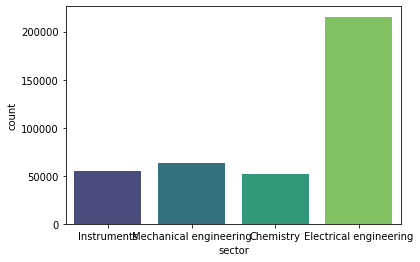

In [82]:
# Look at the counts for each category
ax = sns.countplot(x='sector', data=df_master, palette='viridis')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


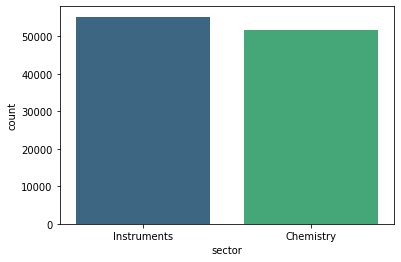

In [103]:
# drop large sectors
df = df_master[df_master.sector != 'Electrical engineering']
df = df[df_master.sector != 'Mechanical engineering']
ax = sns.countplot(x='sector', data=df, palette='viridis')

In [104]:
acceptable = re.compile('[a-zA-Z ]') # regex expression to keep letters and handles

# make a list of the text that fits with regex above
cleanedtext = []
for text in df.text:
    p = ''.join(acceptable.findall(text)).lower()
    cleanedtext.append(p)
df['cleaned_text'] = cleanedtext
df

,patent_id,sector,text,cleaned_text
7751,9226709,Instruments,"A medical system for use with a patient, the s...",a medical system for use with a patient the sy...
7752,9226712,Instruments,A sensor comprising: a sensor pad having a fir...,a sensor comprising a sensor pad having a firs...
7753,9226714,Instruments,A method for displaying glucose information to...,a method for displaying glucose information to...
7754,9226716,Instruments,A nuclear medicine imaging apparatus comprisin...,a nuclear medicine imaging apparatus comprisin...
7755,9226717,Instruments,"A helmet-type brain PET device, comprising: a ...",a helmettype brain pet device comprising a hel...
...,...,...,...,...
406278,10435292,Chemistry,"A method for producing a semiconductor module,...",a method for producing a semiconductor module ...
406279,10442681,Chemistry,A micromechanical system provided with a sensi...,a micromechanical system provided with a sensi...
406280,10442683,Chemistry,A microelectromechanical system (MEMS) device ...,a microelectromechanical system mems device pa...
406281,10442685,Chemistry,"A microelectronic package, comprising: first a...",a microelectronic package comprising first and...


In [105]:
# nltk.download('punkt')

In [106]:
# df['tokenized_text'] = df['cleaned_text'].apply(word_tokenize)
# df

In [107]:
# reset the index and review tokenized text
# df = df.reset_index(drop=True)
# df

In [108]:
# def remove_words(col, to_remove):
#     '''
#     Takes a tokenized df column and a list of words and returns the tokens with the words removed.
    
#     Parameters: 
#     df: Single column of dataframe with rows of strings
#     to_remove: List of words to be removed from strings
    
#     Returns: 
#     cleaned: List of strings with desired words removed
    
#     '''
#     cleaned = []
#     for text in col:
#         cleaned.append([w for w in text if w not in to_remove])
#     return cleaned

In [109]:
# remove English language stopwords and add revisions to new column
# stopwords_list = stopwords.words('english')
# df['stopped_tokens'] = remove_words(df['tokenized_text'], stopwords_list)
# df

In [110]:
# Lemmatize stopped tokens and create new column with lemmed words
# lemmatizer = WordNetLemmatizer()
# lemmed_tokens=[]
# for text in df['stopped_tokens']:
#     lemmed_tokens.append([lemmatizer.lemmatize(w) for w in text]) 
# df['lemmed_tokens'] = lemmed_tokens
# df

In [111]:
# y = df['sector'].apply(lambda x: ' '.join(x))
# X = df['lemmed_tokens'].apply(lambda x: ' '.join(x))

In [112]:
y = df['sector']
X = df['cleaned_text']

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

In [114]:
vec = CountVectorizer(min_df=0.1, max_df=0.9)

In [115]:
X_train_transformed = vec.fit_transform(X_train)
X_train = pd.DataFrame(X_train_transformed.toarray(), columns = vec.get_feature_names())

X_test_transformed = vec.transform(X_test)
X_test = pd.DataFrame(X_test_transformed.toarray(), columns = vec.get_feature_names())

In [116]:
def train_and_predict(model, X_train, y_train):
    '''
    Given a model and train and test data, function fits the model and returns predicted values.
    
    Parameters: 
    model: object containing initialized model for training
    Xy: object containing train and test data for X and y sets
    
    Returns:
    Xy: updated Xy object with X & y prediction data (y_hat_train and y_hat_test)
    
    '''
    model.fit(X_train, y_train)
    
    # Make predictions for test data
    y_hat_train = model.predict(X_train)
    
    # Make predictions for test data
    y_hat_test = model.predict(X_test)
    
    return y_hat_train, y_hat_test

In [117]:
def model_scores(model, 
                 X_train, X_test, 
                 y_train, y_test, 
                 y_hat_train, y_hat_test):
    '''
    Takes model and test train data objects and generates scores and confusion matrix.
    
    Parameters: 
    model: object containing initialized model for training
    Xy: object containing train and test data for X and y sets
    
    Returns:
    printed text and visualizations
    '''
    # Caclulate accuracy for test data
    train_accuracy = accuracy_score(y_train, y_hat_train)
    print('Training Accuracy: {:.4}%'.format(train_accuracy * 100))

    # Caclulate accuracy for test data
    test_accuracy = accuracy_score(y_test, y_hat_test)
    print('Test Accuracy: {:.4}%\n'.format(test_accuracy * 100))

    # Caclulate recall for train data
    train_f1 = recall_score(y_train, y_hat_train, pos_label='Chemistry')
    print('Training Recall Score: {:.4}%'.format(train_f1 * 100))

    # Calculate recall for test data
    test_f1 = recall_score(y_test, y_hat_test, pos_label='Chemistry')
    print('Test Recall Score: {:.4}%\n'.format(test_f1 * 100))    

    # Caclulate F1 for train data
    train_f1 = f1_score(y_train, y_hat_train, pos_label='Chemistry')
    print('Training F1 Score: {:.4}%'.format(train_f1 * 100))

    # Calculate F1 for test data
    test_f1 = f1_score(y_test, y_hat_test, pos_label='Chemistry')
    print('Test F1 Score: {:.4}%'.format(test_f1 * 100))

    # Plot confusion matrix
    print('\nConfusion Matrix for test data')
    plot_confusion_matrix(model, X=X_test, y_true=y_test, values_format = 'd')
    plt.show()

Training Accuracy: 86.61%
Test Accuracy: 86.37%

Training Recall Score: 85.1%
Test Recall Score: 84.9%

Training F1 Score: 86.01%
Test F1 Score: 85.66%

Confusion Matrix for test data


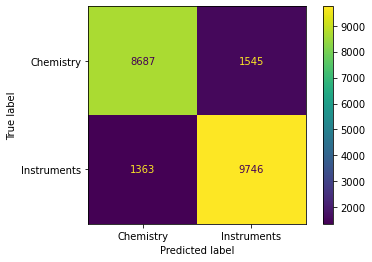

In [118]:
# Initiate the model
logreg = LogisticRegression(random_state=42, n_jobs=1)

logreg.fit(X_train, y_train)

# Make predictions for test data
y_hat_train = logreg.predict(X_train)

# Make predictions for test data
y_hat_test = logreg.predict(X_test)

# Evaluate model
model_scores(logreg, 
             X_train, X_test, 
             y_train, y_test, 
             y_hat_train, y_hat_test)

Training Accuracy: 100.0%
Test Accuracy: 80.68%

Training Recall Score: 100.0%
Test Recall Score: 80.78%

Training F1 Score: 100.0%
Test F1 Score: 80.04%

Confusion Matrix for test data


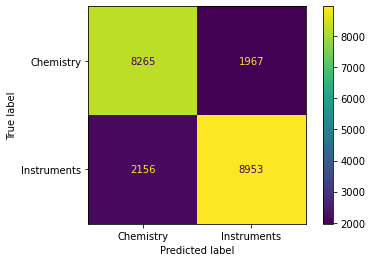

In [125]:
# Initiate the model
dt = DecisionTreeClassifier(random_state=42)  
dt.fit(X_train, y_train)

# Make predictions for test data
y_hat_train = dt.predict(X_train)

# Make predictions for test data
y_hat_test = dt.predict(X_test)

# Evaluate model
model_scores(dt, 
             X_train, X_test, 
             y_train, y_test, 
             y_hat_train, y_hat_test)

In [129]:
def run_grid_search(params, model, X_train, y_train):
    '''
    Takes in parameters, model, and test train data, runs grid search, and 
    returns updated model and test train data.
    
    Parameters: 
    params: dict with parameters for grid search
    model: object containing initialized model for training
    Xy: object containing train and test data for X and y sets
    
    Returns:
    gs: object containing updated model
    Xy: object with test train data
    '''
    gs = GridSearchCV(model, params, scoring='f1_macro', cv=None, n_jobs=1)
    gs = gs.fit(X_train, y_train)
    best_parameters = gs.best_params_

    print('Grid Search found the following optimal parameters: ')
    for param_name in sorted(best_parameters.keys()):
        print('%s: %r' % (param_name, best_parameters[param_name]))

    # Make predictions for test data
    y_hat_train = gs.predict(X_train)
    
    # Make predictions for test data
    y_hat_test = gs.predict(X_test)
    
    return gs, y_hat_train, y_hat_test

Grid Search found the following optimal parameters: 
criterion: 'gini'
max_depth: 9
min_samples_leaf: 3
min_samples_split: 3
Training Accuracy: 86.05%
Test Accuracy: 85.12%

Training Recall Score: 79.73%
Test Recall Score: 78.64%

Training F1 Score: 84.68%
Test F1 Score: 83.52%

Confusion Matrix for test data


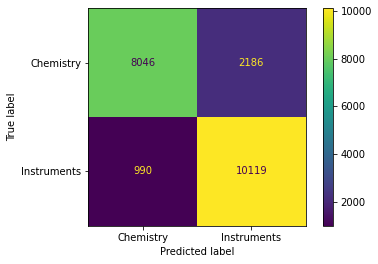

In [130]:
# define parameters to search
params_dt = {
    'criterion':['gini', 'entropy'],
    'max_depth':range(2,10),
    'min_samples_split':range(3,10),
    'min_samples_leaf':range(3,5)
    }

# run grid search
dt, y_hat_train, y_hat_test = run_grid_search(params_dt, dt, X_train, y_train)

# Evaluate model
model_scores(dt, 
             X_train, X_test, 
             y_train, y_test, 
             y_hat_train, y_hat_test)

Training Accuracy: 87.69%
Test Accuracy: 87.29%

Training Recall Score: 83.6%
Test Recall Score: 83.21%

Training F1 Score: 86.79%
Test F1 Score: 86.26%

Confusion Matrix for test data


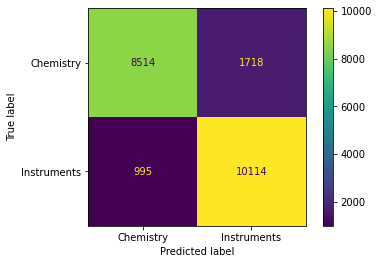

In [132]:
# Initiate the model
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

# Make predictions for test data
y_hat_train = xgb.predict(X_train)

# Make predictions for test data
y_hat_test = xgb.predict(X_test)

# Evaluate model
model_scores(xgb, 
             X_train, X_test, 
             y_train, y_test, 
             y_hat_train, y_hat_test)

In [119]:
# from gensim.models import Word2Vec
# from nltk import word_tokenize

In [120]:
# import nltk
# nltk.download('punkt')

In [121]:
# data = df['text'].map(word_tokenize)
# data[:5]

In [122]:
# model = Word2Vec(data, size=100, window=5, min_count=1, workers=4)
# model.train(data, total_examples=model.corpus_count, epochs=10)
# wv = model.wv